In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

path='archive/Data/Audio/'

# Data


In [2]:
for (dirpath, dirnames, filenames) in os.walk(path):
    if not dirnames:
        print(dirpath)
        print(len(os.listdir(dirpath)))

archive/Data/Audio/Female\PTDB-TUG
120
archive/Data/Audio/Female\TMIT
205
archive/Data/Audio/Male\PTDB-TUG
120
archive/Data/Audio/Male\TMIT
64
archive/Data/Audio/Noizeus\Babble
30
archive/Data/Audio/Noizeus\Car
30
archive/Data/Audio/Noizeus\NoNoise
30
archive/Data/Audio/Noizeus\Restaurant
30
archive/Data/Audio/Noizeus\Station
30
archive/Data/Audio/Noizeus\Street
30
archive/Data/Audio/Noizeus\Train
30


# Making Spectrogram for each voice


spectrogram/Female\PTDB-TUG
spectrogram/Female\TMIT
spectrogram/Male\PTDB-TUG
spectrogram/Male\TMIT
spectrogram/Noizeus\Babble
spectrogram/Noizeus\Car
spectrogram/Noizeus\NoNoise
spectrogram/Noizeus\Restaurant
spectrogram/Noizeus\Station
spectrogram/Noizeus\Street
spectrogram/Noizeus\Train


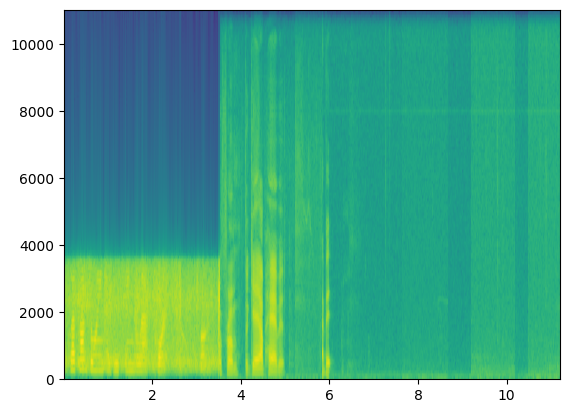

In [3]:
root='spectrogram/'
folders=["Female","Male","Noizeus"]
for (dirpath, dirnames, filenames) in os.walk(path):
    if filenames:
        for i in folders:
            if i in dirpath :
                k=os.path.join(root,dirpath.split("Audio/")[-1])
                print(k)
                if not os.path.exists(k):
                    os.mkdir(k)
                
                for i in filenames:
                    path=os.path.join(dirpath,i)
                    wave,sr=librosa.load(path)
                    plt.specgram(wave,Fs=sr)
                    plt.savefig(os.path.join(k,i+".png"))
    

# Voice Classification


In [2]:
import tensorflow as tf
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          validation_split=0.2)

In [3]:
spec_dir="spectrogram/"
train_generator = datagen.flow_from_directory(
        spec_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode="categorical",
        subset="training",
        shuffle=True)

Found 576 images belonging to 3 classes.


In [4]:
val_generator = datagen.flow_from_directory(
        spec_dir,  
        target_size=(150, 150),  
        batch_size=16,
        class_mode="categorical",
        subset="validation",
        shuffle=True)

Found 143 images belonging to 3 classes.


In [5]:
from keras.layers import Input
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import Sequential,Model,layers

input_size=train_generator.image_shape
def get_encoder(input_size):
    model=Sequential()
    model.add(layers.Conv2D(32,(3,3),input_shape=input_size,activation='relu'))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.GlobalMaxPool2D())
    return model

encoder=get_encoder(input_size)
input1=Input(input_size)
encoder=encoder(input1)
output=layers.Dense(3,activation='softmax')(encoder)
model=Model(inputs=input1,outputs=output)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128)               314688    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 315075 (1.20 MB)
Trainable params: 315075 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
checkpoint_filepath = 'model/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

early = EarlyStopping(patience=5,
                      min_delta=0.001,
                      restore_best_weights=True)

In [8]:
model.fit(train_generator,epochs=30,validation_data=val_generator,callbacks=[model_checkpoint_callback,early])

Epoch 1/30


18/18 [==============================] - 16s 810ms/step - loss: 0.6360 - accuracy: 0.4340 - val_loss: 0.6339 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 15s 830ms/step - loss: 0.6237 - accuracy: 0.4514 - val_loss: 0.6526 - val_accuracy: 0.4545
Epoch 3/30
18/18 [==============================] - 16s 907ms/step - loss: 0.6239 - accuracy: 0.4514 - val_loss: 0.6272 - val_accuracy: 0.4545
Epoch 4/30
18/18 [==============================] - 17s 958ms/step - loss: 0.6011 - accuracy: 0.4514 - val_loss: 0.5723 - val_accuracy: 0.4895
Epoch 5/30
18/18 [==============================] - 17s 963ms/step - loss: 0.4624 - accuracy: 0.6597 - val_loss: 0.3601 - val_accuracy: 0.7483
Epoch 6/30
18/18 [==============================] - 17s 954ms/step - loss: 0.3660 - accuracy: 0.7083 - val_loss: 0.3564 - val_accuracy: 0.7483
Epoch 7/30
18/18 [==============================] - 17s 931ms/step - loss: 0.3302 - accuracy: 0.7378 - val_loss: 0.4378 - val_accuracy: 0.54

In [9]:
model.evaluate(val_generator)

9/9 [==============================] - 1s 128ms/step - loss: 0.3434 - accuracy: 0.7483


[0.34341442584991455, 0.748251736164093]

# Adding Noise to Audio Files


noisy_spectrogram/Female\PTDB-TUG
noisy_spectrogram/Female\TMIT
noisy_spectrogram/Male\PTDB-TUG
noisy_spectrogram/Male\TMIT
noisy_spectrogram/Noizeus\Babble
noisy_spectrogram/Noizeus\Car
noisy_spectrogram/Noizeus\NoNoise
noisy_spectrogram/Noizeus\Restaurant
noisy_spectrogram/Noizeus\Station
noisy_spectrogram/Noizeus\Street
noisy_spectrogram/Noizeus\Train


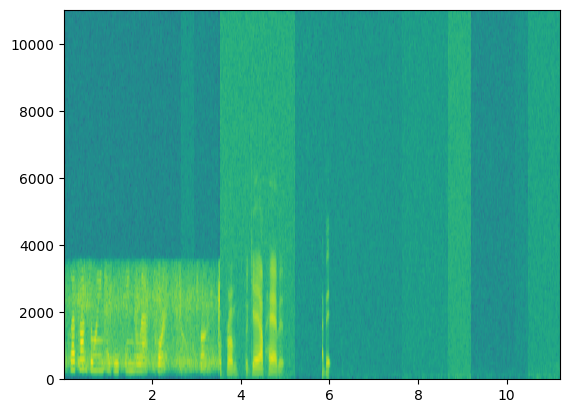

In [2]:
root='noisy_spectrogram/'
folders=["Female","Male","Noizeus"]
for (dirpath, dirnames, filenames) in os.walk(path):
    if filenames:
        for i in folders:
            if i in dirpath :
                k=os.path.join(root,dirpath.split("Audio/")[-1])
                print(k)
                if not os.path.exists(k):
                    os.mkdir(k)
                
                for i in filenames:
                    path=os.path.join(dirpath,i)
                    wave,sr=librosa.load(path)
                    noise = np.random.normal(0,0.001, wave.shape[0])
                    noisy_wave=wave+noise
                    plt.specgram(noisy_wave,Fs=sr)
                    plt.savefig(os.path.join(k,i+".png"))

# Voice Classification


In [4]:
import tensorflow as tf
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          validation_split=0.2)

In [5]:
spec_dir="noisy_spectrogram/"
train_generator = datagen.flow_from_directory(
        spec_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode="categorical",
        subset="training",
        shuffle=True)

Found 576 images belonging to 3 classes.


In [6]:
val_generator = datagen.flow_from_directory(
        spec_dir,  
        target_size=(150, 150),  
        batch_size=16,
        class_mode="categorical",
        subset="validation",
        shuffle=True)

Found 143 images belonging to 3 classes.


In [7]:
from keras.layers import Input
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import Sequential,Model,layers

input_size=train_generator.image_shape
def get_encoder(input_size):
    model=Sequential()
    model.add(layers.Conv2D(32,(3,3),input_shape=input_size,activation='relu'))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.GlobalMaxPool2D())
    return model

encoder=get_encoder(input_size)
input1=Input(input_size)
encoder=encoder(input1)
output=layers.Dense(3,activation='softmax')(encoder)
model_noisy=Model(inputs=input1,outputs=output)

model_noisy.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
model_noisy.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128)               314688    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 315075 (1.20 MB)
Trainable params: 315075 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
checkpoint_filepath = 'model/ckpt_noise/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

early = EarlyStopping(patience=5,
                      min_delta=0.001,
                      restore_best_weights=True)

In [10]:
model_noisy.fit(train_generator,
          epochs=30,
          validation_data=val_generator,
          callbacks=[model_checkpoint_callback,early])

Epoch 1/30


18/18 [==============================] - 19s 967ms/step - loss: 0.6324 - accuracy: 0.4479 - val_loss: 0.6355 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 15s 849ms/step - loss: 0.6271 - accuracy: 0.4514 - val_loss: 0.6489 - val_accuracy: 0.4545
Epoch 3/30
18/18 [==============================] - 19s 1s/step - loss: 0.6253 - accuracy: 0.4514 - val_loss: 0.6229 - val_accuracy: 0.4545
Epoch 4/30
18/18 [==============================] - 18s 984ms/step - loss: 0.6219 - accuracy: 0.4514 - val_loss: 0.6222 - val_accuracy: 0.4545
Epoch 5/30
18/18 [==============================] - 18s 981ms/step - loss: 0.6136 - accuracy: 0.4931 - val_loss: 0.5983 - val_accuracy: 0.4545
Epoch 6/30
18/18 [==============================] - 18s 968ms/step - loss: 0.5263 - accuracy: 0.5990 - val_loss: 0.3735 - val_accuracy: 0.7343
Epoch 7/30
18/18 [==============================] - 17s 964ms/step - loss: 0.4146 - accuracy: 0.6858 - val_loss: 0.3383 - val_accuracy: 0.7413


In [11]:
model_noisy.evaluate(val_generator)

9/9 [==============================] - 1s 140ms/step - loss: 0.0097 - accuracy: 0.9930


[0.009728360921144485, 0.9930070042610168]

In [12]:
k=tf.keras.models.load_model(checkpoint_filepath)
k.evaluate(val_generator)

9/9 [==============================] - 2s 138ms/step - loss: 0.1548 - accuracy: 1.0000


[0.15478195250034332, 1.0]